**<h1 style="text-align: center;">DETECTING AND IDENTIFYING FRAUDULENT JOB POSTING</h1>**


**INSTALLATION**

In [3]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/39/4a/2684863905b72fceea24edaa10e3e16bc742a184042f463f3b09883d75b0/wordcloud-1.9.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 400.3 kB/s eta 0:00:00a 0:00:01


In [61]:
!pip install scapy && python -m download en

/Users/khushi/anaconda3/bin/python: No module named download


In [106]:
! pip install nltk

In [173]:
pip install --upgrade scikit-learn


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/ce/41/5d882544fddba1ae476c240cdf4499743ea84bfeb54456d472966dc86355/scikit_learn-1.4.1.post1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 3.6 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
Note: you may need to restart the kernel to use updated packages.


**IMPORT LIBRARIES**

In [52]:
import re
import string
import numpy as np
import pandas as pd
import random
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.stem import PorterStemmer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.base import TransformerMixin


print("✔ Libraries Imported Successfully")

✔ Libraries Imported Successfully


**LOAD DATASET**

In [53]:
df = pd.read_csv("fake_job_postings.csv")

**DATASET VIEW**

In [54]:
df.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


**DATA PRE-PROCESSING**

In [55]:
df.shape

(17880, 18)

In [56]:
df.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

In [57]:
df.iloc[0].department

'Marketing'

In [58]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [59]:
# handling missing values
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

**DUPLICATE ROWS**

In [60]:
# find duplicate rows
df.duplicated().sum()

0

In [61]:
columns = ["job_id", "telecommuting", "has_company_logo", "has_questions", "salary_range", "employment_type"]
for col in columns:
    del df[col]

In [62]:
df.head(2)

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [63]:
df.fillna('', inplace = True)

In [64]:
df.describe

<bound method NDFrame.describe of                                                    title  \
0                                       Marketing Intern   
1              Customer Service - Cloud Video Production   
2                Commissioning Machinery Assistant (CMA)   
3                      Account Executive - Washington DC   
4                                    Bill Review Manager   
...                                                  ...   
17875                   Account Director - Distribution    
17876                                 Payroll Accountant   
17877  Project Cost Control Staff Engineer - Cost Con...   
17878                                   Graphic Designer   
17879                         Web Application Developers   

                   location   department  \
0          US, NY, New York    Marketing   
1            NZ, , Auckland      Success   
2             US, IA, Wever                
3        US, DC, Washington        Sales   
4        US, FL, Fort Wor

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17880 non-null  object
 2   department           17880 non-null  object
 3   company_profile      17880 non-null  object
 4   description          17880 non-null  object
 5   requirements         17880 non-null  object
 6   benefits             17880 non-null  object
 7   required_experience  17880 non-null  object
 8   required_education   17880 non-null  object
 9   industry             17880 non-null  object
 10  function             17880 non-null  object
 11  fraudulent           17880 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 1.6+ MB


In [66]:
df.shape

(17880, 12)

**VISUALISATION**

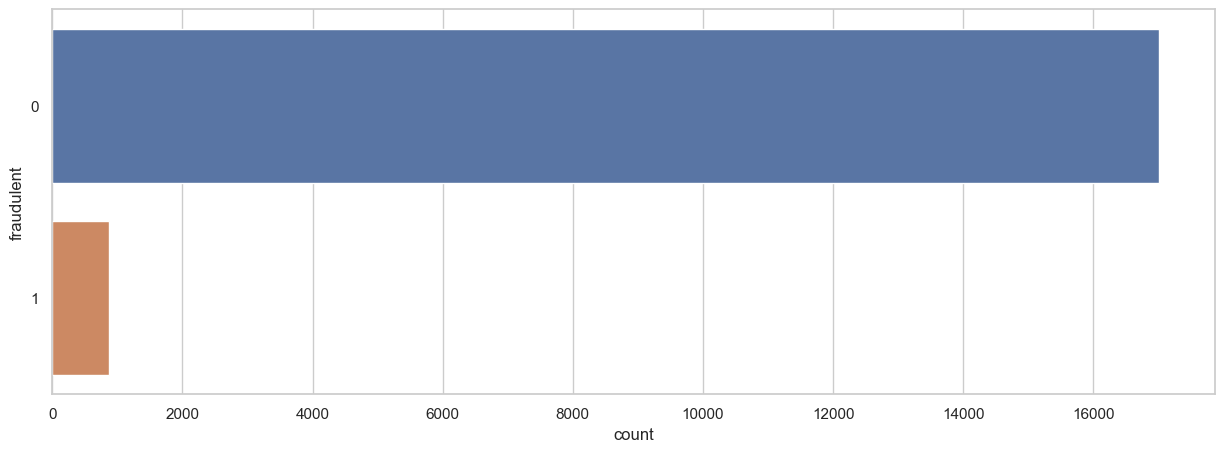

In [67]:
# Visualize the fraudulent job
plt.figure(figsize = (15,5))
sns.countplot(y = "fraudulent", data = df)
plt.show()

**- So as you can see majority number of jobs posted are non-fraudulent while some of the jobsposted are fraudulent.**

In [68]:
# Count the fraudulent and non-fradulent jobs
df.groupby("fraudulent")["fraudulent"].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

**- In the dataset 17014 jobs are non-fraudulent and 866 jobs are fraudulent.** 

In [69]:
# Number of jobs posted for that particular category
exp = dict(df.required_experience.value_counts())
del exp[""]

In [70]:
exp

{'Mid-Senior level': 3809,
 'Entry level': 2697,
 'Associate': 2297,
 'Not Applicable': 1116,
 'Director': 389,
 'Internship': 381,
 'Executive': 141}

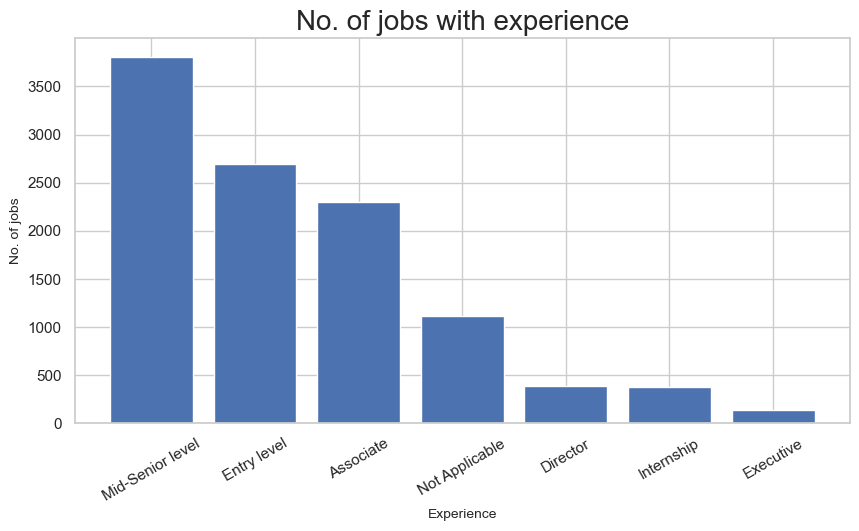

In [71]:
# Maximum number of jobs posted with required experience
plt.figure(figsize = (10,5))
sns.set_theme(style = "whitegrid")
plt.bar(exp.keys(), exp.values())
plt.title("No. of jobs with experience", size =20)
plt.xlabel("Experience", size = 10)
plt.ylabel("No. of jobs", size = 10)
plt.xticks(rotation = 30)
plt.show()

**- So according to the dataset the maximum number of jobs posted required experience of Mid-Senior level after that we have Entry level then Associate and so on.**

In [72]:
# Create another column of country
def split(location):
    l = location.split(',')
    return l[0]
df["country"] = df.location.apply(split)

In [73]:
df.head(2)

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ


**- Country column created in the dataset.**

In [74]:
# Number of job posted for the top 14 countries
cou = dict(df.country.value_counts()[:14])
del cou['']
cou

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132,
 'NL': 127,
 'BE': 117,
 'IE': 114,
 'SG': 80}

**- Here, we have top 14 countries and the count.**

Text(0, 0.5, 'No. of jobs')

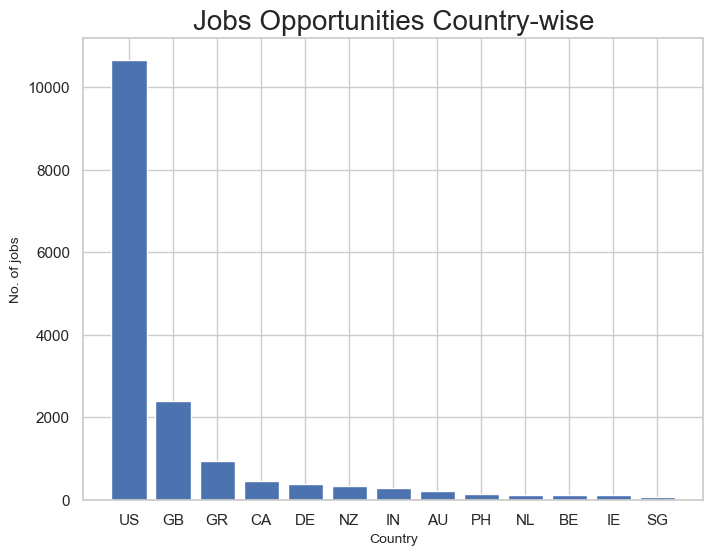

In [75]:
# Visualize the number of job posted for the top 14 countries
plt.figure(figsize = (8,6))
plt.bar(cou.keys(), cou.values())
plt.title("Jobs Opportunities Country-wise", size =20)
plt.xlabel("Country", size = 10)
plt.ylabel("No. of jobs", size = 10)

**- The maximum number of jobs posted in US**

In [76]:
# Education level and job posted each of that education
# Create a key value pair or the dictionary and then visualize the data
edu = dict(df.required_education.value_counts()[:5])
del edu['']
edu

{"Bachelor's Degree": 5145,
 'High School or equivalent': 2080,
 'Unspecified': 1397,
 "Master's Degree": 416}

Text(0, 0.5, 'No. of jobs')

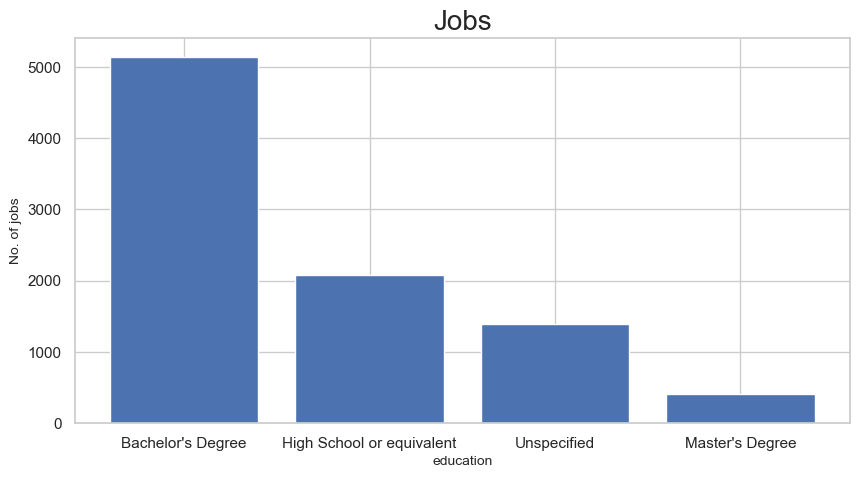

In [77]:
plt.figure(figsize = (10,5))
plt.bar(edu.keys(), edu.values())
plt.title("Jobs", size =20)
plt.xlabel("education", size = 10)
plt.ylabel("No. of jobs", size = 10)

**- The maximum number of jobs the education level required Bachelor's Degree.**

In [78]:
# Most commonly used 7 titles
print(df[df.fraudulent == 0].title.value_counts()[:7])

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Name: count, dtype: int64


**- These were the most common titles that were used when the jobs posted were not actually fraudulent.**

In [79]:
# Most commonly titles when the job posted fraudulent
print(df[df.fraudulent == 1].title.value_counts()[:5])

title
Data Entry Admin/Clerical Positions - Work From Home               21
Home Based Payroll Typist/Data Entry Clerks Positions Available    21
Cruise Staff Wanted *URGENT*                                       21
Customer Service Representative                                    17
Administrative Assistant                                           16
Name: count, dtype: int64


**- These were the top 5 titlesused for jobthat were fraudulent.**

In [80]:
# Combine all columns into single coulumn
df['text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']

**- So, now rest of the columns will be deleted.**

In [81]:
df.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


**- Now, we are left with only two columns here one is whether or not the job posted is fraudulent and other is a text column.** 

In [82]:
# Create a WordCloud based on text
fraud_job_text = df[df.fraudulent == 1].text
genuine_job_text = df[df.fraudulent == 0].text

**- Storing all the fraudulent job text and non - fraudulent job text in the variables.**

In [83]:
wordcloud = WordCloud(width = 800, height = 800,
                      background_color = "white",
                      min_font_size = 10)

In [84]:
df[df["fraudulent"] == 1]["text"]

98       IC&E Technician                               ...
144      Forward Cap.  The group has raised a fund for ...
173      Technician Instrument & Controls  Edison Inter...
180      Sales Executive  Sales Executive Sales Executi...
215      IC&E Technician Mt Poso                       ...
                               ...                        
17827    Student Positions Part-Time and Full-Time.  St...
17828    Sales Associate  LEARN TO EARN AN EXECUTIVE LE...
17829    Android Developer  inFullMobile Sp. z o.o. is ...
17830    Payroll Clerk   JOB DESCRIPTIONWe are seeking ...
17831    Furniture mover Anthony Warren is a Marketing ...
Name: text, Length: 866, dtype: object

In [85]:
fraud_job_text = wordcloud.generate(" ".join(df[df["fraudulent"] == 1]["text"]))

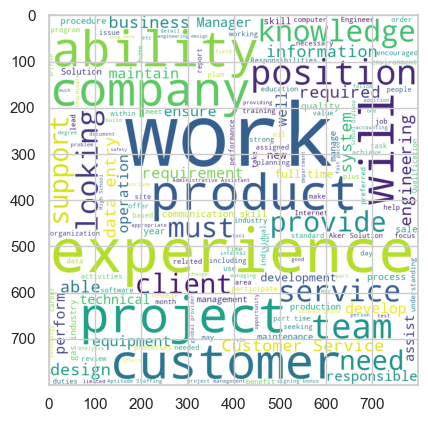

In [86]:
plt.imshow(fraud_job_text)

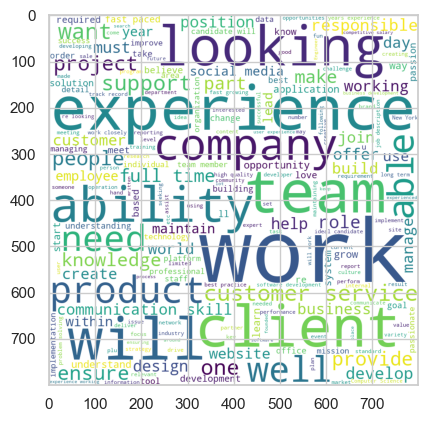

In [87]:
genuine_job_text = wordcloud.generate(" ".join(df[df["fraudulent"] == 0]["text"]))
plt.imshow(genuine_job_text)

In [38]:
import spacy
spacy.cli.download("en_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.9 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [88]:
# Cleaning and preprocessing
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load english tokenizer, tagger, parser, NER and word vectors
parser = English()

#our tokenizer function
def spacy_tokenizer(sentence):
    
    # Creating our token object, which is used to create documents with linguistic annotation
    mytokens = parser(sentence)
    
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "PRON-" else word.lower_ for word in mytokens]
    
    # Removing stop words
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    # Return a preprocessed liost of tokens
    return mytokens

# Custom transformer using spacy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return[clean_text(text) for text in X]
    def fit(self, X, y = None, **fit_params):
        return self
    def get_params(self, deep = True):
        return{}

    
def clean_text(text):
    return text.strip().lower()


In [89]:
df["text"] = df["text"].apply(clean_text)

**WORD2VEC**

In [92]:
vectorizer = TfidfVectorizer(max_features = 100)

In [93]:
x = vectorizer.fit_transform(df["text"])

In [94]:
vectorizer.get_feature_names_out()

array(['ability', 'about', 'all', 'also', 'amp', 'an', 'and', 'are', 'as',
       'at', 'based', 'be', 'best', 'business', 'but', 'by', 'can',
       'client', 'clients', 'communication', 'company', 'customer',
       'customers', 'data', 'design', 'development', 'do', 'environment',
       'experience', 'for', 'from', 'full', 'has', 'have', 'help', 'high',
       'if', 'in', 'including', 'industry', 'is', 'it', 'job',
       'knowledge', 'looking', 'management', 'marketing', 'more', 'must',
       'new', 'not', 'of', 'office', 'on', 'one', 'opportunity', 'or',
       'other', 'our', 'people', 'position', 'product', 'products',
       'project', 'provide', 'quality', 're', 'required', 'sales',
       'service', 'services', 'skills', 'software', 'solutions', 'strong',
       'support', 'team', 'technical', 'technology', 'that', 'the',
       'their', 'this', 'through', 'time', 'to', 'up', 'us', 'we', 'web',
       'well', 'who', 'will', 'with', 'work', 'working', 'world', 'years',
     

In [95]:
tf = TfidfVectorizer(max_features = 100)

x = tf.fit_transform(df["text"])

print(x.toarray())

[[0.         0.04112003 0.         ... 0.         0.         0.        ]
 [0.02189474 0.09418271 0.0353937  ... 0.         0.20485423 0.13045163]
 [0.         0.         0.17680709 ... 0.         0.09446187 0.0744758 ]
 ...
 [0.04301136 0.04625456 0.         ... 0.07322877 0.12382404 0.07321918]
 [0.         0.         0.06188893 ... 0.         0.1653255  0.13034622]
 [0.         0.02498405 0.03755586 ... 0.         0.30097178 0.07909757]]


In [96]:
df1 = pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out())

In [97]:
tf.get_feature_names_out()

array(['ability', 'about', 'all', 'also', 'amp', 'an', 'and', 'are', 'as',
       'at', 'based', 'be', 'best', 'business', 'but', 'by', 'can',
       'client', 'clients', 'communication', 'company', 'customer',
       'customers', 'data', 'design', 'development', 'do', 'environment',
       'experience', 'for', 'from', 'full', 'has', 'have', 'help', 'high',
       'if', 'in', 'including', 'industry', 'is', 'it', 'job',
       'knowledge', 'looking', 'management', 'marketing', 'more', 'must',
       'new', 'not', 'of', 'office', 'on', 'one', 'opportunity', 'or',
       'other', 'our', 'people', 'position', 'product', 'products',
       'project', 'provide', 'quality', 're', 'required', 'sales',
       'service', 'services', 'skills', 'software', 'solutions', 'strong',
       'support', 'team', 'technical', 'technology', 'that', 'the',
       'their', 'this', 'through', 'time', 'to', 'up', 'us', 'we', 'web',
       'well', 'who', 'will', 'with', 'work', 'working', 'world', 'years',
     

In [98]:
df.drop(["text"], axis = 1, inplace = True)
main_df = pd.concat([df1, df], axis = 1)

In [99]:
main_df.head()

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.041120,0.000000,0.042424,0.036488,0.000000,0.755238,0.000000,0.078653,0.000000,...,0.000000,0.000000,0.186067,0.051026,0.068029,0.000000,0.000000,0.000000,0.000000,0
1,0.021895,0.094183,0.035394,0.024292,0.041787,0.029771,0.490896,0.056626,0.060050,0.052431,...,0.000000,0.078004,0.165735,0.043827,0.116862,0.099327,0.000000,0.204854,0.130452,0
2,0.000000,0.000000,0.176807,0.000000,0.041749,0.089231,0.397029,0.113149,0.000000,0.000000,...,0.000000,0.062346,0.307512,0.058383,0.000000,0.000000,0.000000,0.094462,0.074476,0
3,0.023267,0.000000,0.018806,0.000000,0.000000,0.094909,0.695542,0.000000,0.031906,0.037144,...,0.023132,0.049735,0.075480,0.046573,0.000000,0.105551,0.019806,0.050236,0.059411,0
4,0.000000,0.000000,0.068009,0.000000,0.040147,0.028602,0.606379,0.081605,0.115386,0.000000,...,0.000000,0.000000,0.159230,0.028071,0.037425,0.000000,0.035814,0.030279,0.107427,0


**- So these are all words that are present in our dataset and these are frequencies of the appearance of these words.**

**TRAIN - TEST SPLIT**

In [100]:
# Train-test split
y = main_df.iloc[:, -1]
X = main_df.iloc[:, :-1]

**- So we are going to include all the columns that are present (it's a words) and the last column which is whether or not fraudulent like the job posted is fraudulent or not.**

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12516, 100)
(12516,)
(5364, 100)
(5364,)


**APPLY MODELS**

**IMPORT RANDOM FOREST MODEL**

In [113]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [114]:
from sklearn.metrics import accuracy_score

pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
score

0.9668158090976883

In [117]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report\n")
print(classification_report(y_test, pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test, pred))



Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5085
           1       1.00      0.36      0.53       279

    accuracy                           0.97      5364
   macro avg       0.98      0.68      0.76      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5085    0]
 [ 178  101]]


**- So, here in the report we can see all the values so as to better understand how our model works apart from that we also have confusion matrix.**

**- The overall accuracy appears to be good.**

**IMPORT SUPPORT VECTOR MACHINE MODEL**

In [118]:
#train - test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=24)

print(f'Shape of X_train -: {X_train.shape}')
print(f'Shape of X_test -: {X_test.shape}')
print(f'Shape of y_train -: {y_train.shape}')
print(f'Shape of y_test -: {y_test.shape}')

Shape of X_train -: (14304, 100)
Shape of X_test -: (3576, 100)
Shape of y_train -: (14304,)
Shape of y_test -: (3576,)


In [119]:
pd.Series(y_train).value_counts()

fraudulent
0    13607
1      697
Name: count, dtype: int64

In [120]:
pd.Series(y_test).value_counts()

fraudulent
0    3407
1     169
Name: count, dtype: int64

In [122]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [126]:
from sklearn.svm import SVC
model2 = SVC()

In [127]:
model2.fit(X_train, y_train)

SVC()

In [128]:
model2.score(X_train, y_train)

0.975251677852349

In [129]:
model2.score(X_test, y_test)

0.9689597315436241

In [130]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3407
           1       0.94      0.37      0.53       169

    accuracy                           0.97      3576
   macro avg       0.95      0.68      0.76      3576
weighted avg       0.97      0.97      0.96      3576

